# Buzzer control analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'buzzer'  # Analysis type
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection

### Derived parameters

In [4]:
# If global correction is dictionary, extract line-specific method
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]

# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)

# Derive output metrics of interest
outkey = get_change_key(ykey_classification)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/02/13 15:54:30: assembling batch analysis settings...
 2024/02/13 15:54:30: sst batch notebook started on 2024-02-13 at 15:54:30


### Input summary table figure

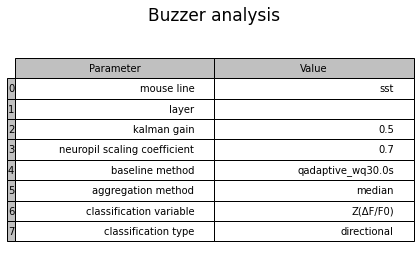

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline method': baseline_id,
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional"
    }, title='Buzzer analysis', aspect=1.5)

## Input data

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = {
    'line3': [
    ],
    'sst': [
        '20190602_mouse7_region2',   # TO DOCUMENT
    ]
}[mouseline]

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer, include_mode='any',
    # exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs,
    harmonize_runs=False, 
    condition='buzzer')

 2024/02/13 15:54:34: loading data from /gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/buzzer/sst:
 2024/02/13 15:54:34: gathering dataset IDs...
 2024/02/13 15:54:34: loading mouse-region data from 20190602_mouse2_region2.h5
 2024/02/13 15:54:34: loading mouse-region data from 20190602_mouse2_region3.h5
 2024/02/13 15:54:34: loading mouse-region data from 20190602_mouse7_region1.h5
 2024/02/13 15:54:34: loading mouse-region data from 20190602_mouse7_region2.h5
 2024/02/13 15:54:35: loading mouse-region data from 20190605_mouse2_region1.h5
 2024/02/13 15:54:35: loading mouse-region data from 20190605_mouse7_region1.h5
 2024/02/13 15:54:35: loading mouse-region data from 20190719_mouse2_region1.h5
 2024/02/13 15:54:35: loading mouse-region data from 20190719_mouse6_region1.h5
 2024/02/13 15:54:35: assembling data structures...
 2024/02/13 15:54:36: sor

### Filter out datasets, classify cells and show breakdown & map per dataset

 2024/02/13 15:54:37: extracting timeseries and stats from data...
 2024/02/13 15:54:37: excluding datasets with missing conditions...
 2024/02/13 15:54:37: cell breakdown:
  - positive: 1065 (74.6%)
  - weak: 362 (25.4%)
 2024/02/13 15:54:37: expanding (6 datasets x 693 ROIs) input dataframe to match (6 datasets x 693 ROIs x 3 runs) reference dataframe
 2024/02/13 15:54:40: plotting cell maps...


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


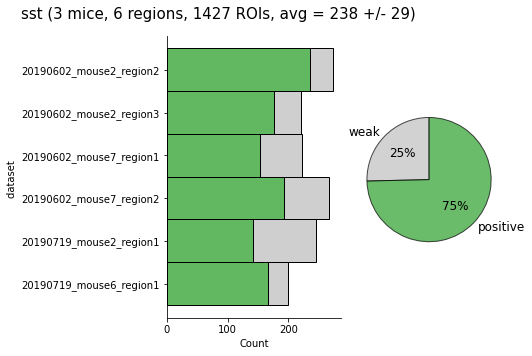

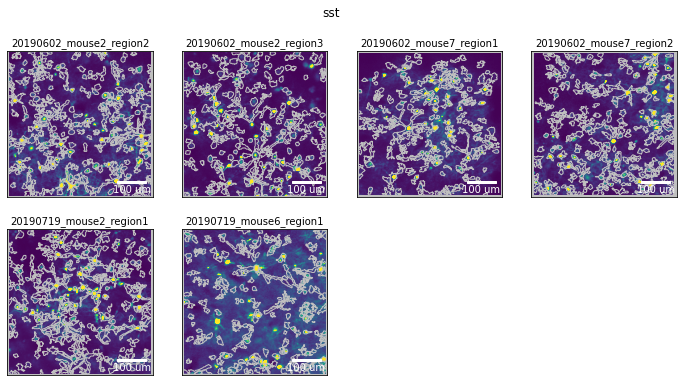

In [7]:
# Extract fields from data
trialagg_timeseries, _, trialagg_stats, _, ROI_masks, map_ops = extract_from_batch_data(data)

# Create conditions column with better names
ckey = 'condition'
condkeys_map = {
    'tus': 'US',
    'sound': 'sound',
    'sound_tus': 'sound+US'
}
trialagg_stats[ckey] = trialagg_stats[Label.SUFFIX].map(condkeys_map)

# Exclude datasets with missing conditions
logger.info('excluding datasets with missing conditions...')
ncondsperdataset = trialagg_stats[ckey].groupby(Label.DATASET).nunique()
valid_datasets = ncondsperdataset[ncondsperdataset == 3].index
trialagg_timeseries = trialagg_timeseries.loc[pd.IndexSlice[valid_datasets]]
trialagg_stats = trialagg_stats.loc[pd.IndexSlice[valid_datasets]]
ROI_masks = ROI_masks.loc[pd.IndexSlice[valid_datasets]]
map_ops = {k: map_ops[k] for k in valid_datasets}

# Compute number of occurences per response type per ROI
roistats = trialagg_stats[Label.RESP_TYPE].groupby(
    [Label.DATASET, Label.ROI]).value_counts().unstack().replace(np.nan, 0.).astype(int)

# Classify ROIs based on number of responsive conditions
roistats[Label.ROI_RESP_TYPE] = 'weak'
roistats.loc[roistats['positive'] >= 1, Label.ROI_RESP_TYPE] = 'positive'

# Log number and percentage of cells of each type identified
ncells_per_type = roistats[Label.ROI_RESP_TYPE].value_counts()
ncells_tot = ncells_per_type.sum()
logstr = []
for rtype, count in ncells_per_type.items():
    logstr.append(f'  - {rtype}: {count} ({count / ncells_tot * 100:.1f}%)')
logstr = "\n".join(logstr)
logger.info(f'cell breakdown:\n{logstr}')

# Add roistats to stats
trialagg_stats = free_expand_and_add(roistats, trialagg_stats.copy())
# trialagg_stats = expand_and_add(roistats, trialagg_stats.copy())

# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(trialagg_stats, title=mouseline)

# Plot cell maps
figs['cellmaps'] = plot_fields_of_view(
    map_ops, 
    refkey='max_proj',
    Fstats=trialagg_stats, 
    ROI_masks=ROI_masks, 
    title=mouseline, 
    mode='contour',
    hue=None,
    qmax=0.99,
)

# # Restrict analysis to positive responders
# logger.info('restricting dataset to positive responders only...')
# mux_pos = trialagg_stats[stats[Label.ROI_RESP_TYPE] == 'positive'].index.droplevel(-1).unique()
# idx_pos = pd.IndexSlice[mux_pos.get_level_values(0), mux_pos.get_level_values(1)]
# trialagg_stats = trialagg_stats.loc[idx_pos, :]
# trialagg_timeseries = trialagg_timeseries.loc[idx_pos, :]

### Plot responders traces vs condition

 2024/02/13 15:54:45: assembling plot data...
 2024/02/13 15:54:45: adding time info to table...
 2024/02/13 15:54:45: plotting responders traces across conditions & datasets...
 2024/02/13 15:54:49: plotting aggregate responders traces across conditions...


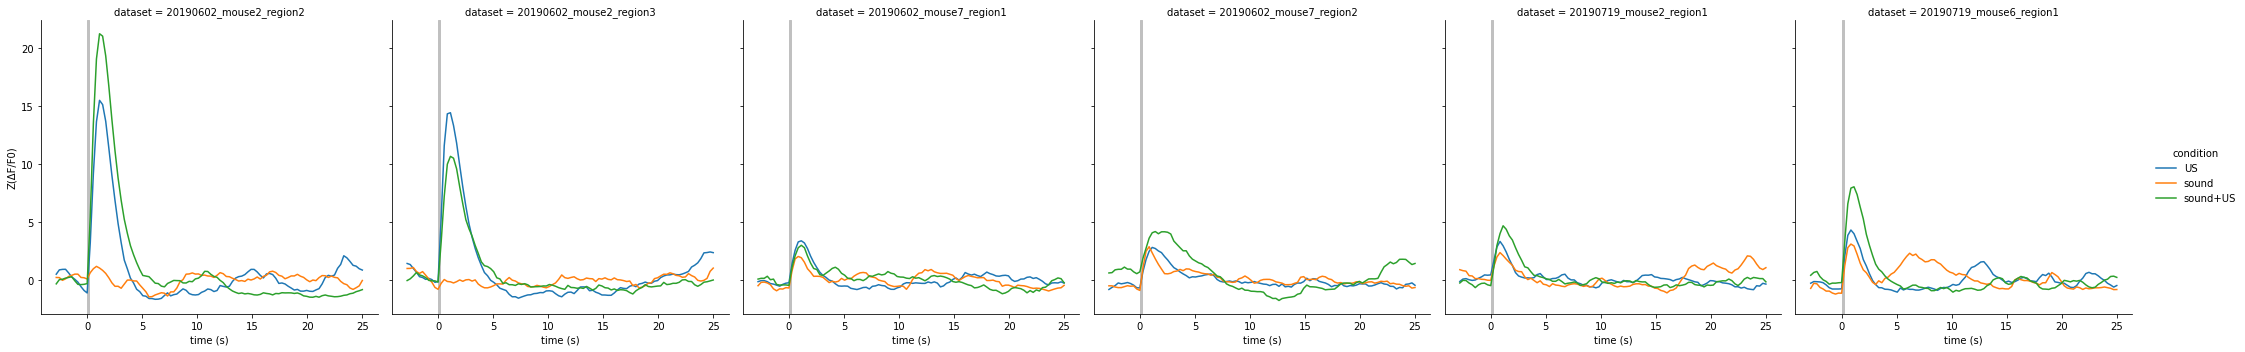

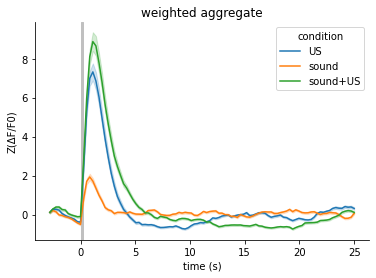

In [8]:
# Get plot data
logger.info('assembling plot data...')
pltdata = expand_and_add(trialagg_stats[ckey], trialagg_timeseries.copy())
# Add time
fps = get_singleton(trialagg_stats, Label.FPS)
pltdata = add_time_to_table(pltdata, fps=fps)

# Plot parameters
palette = None
ykey = ykey_classification

# Stimulus bounds (in seconds)
stim_tbounds = (0, get_singleton(trialagg_stats, Label.DUR)) 

# Plot response traces vs. offset for each dataset
logger.info('plotting responders traces across conditions & datasets...')
fg = sns.relplot(
    data=pltdata, x=Label.TIME, y=ykey, kind='line',
    hue=ckey, col=Label.DATASET, errorbar=None, hue_order=condkeys_map.values())
for ax in fg.axes.ravel():
    ax.axvspan(*stim_tbounds, color='silver')
figs['traces_vs_offset_per_dataset'] = fg.figure

# Plot weighted aggregate response traces vs. offset
logger.info('plotting aggregate responders traces across conditions...')
figs['traces_vs_offset_agg'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('weighted aggregate')
sns.lineplot(
    data=pltdata, x=Label.TIME, y=ykey, ax=ax,
    hue=ckey, errorbar='se', hue_order=condkeys_map.values())
ax.axvspan(*stim_tbounds, color='silver');

### Plot response strength per condition

 2024/02/13 15:54:53: plotting normalized evoked Z(ΔF/F0) change across condition
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US vs. sound: t-test paired samples, P_val:4.643e-02 t=2.632e+00
sound vs. sound+US: t-test paired samples, P_val:1.023e-02 t=-4.010e+00
US vs. sound+US: t-test paired samples, P_val:2.090e-01 t=-1.442e+00


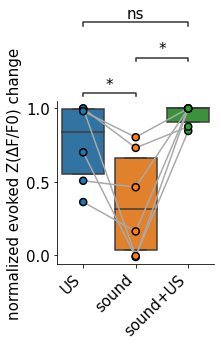

In [9]:
# Compute normalized response strength for each dataset
maxperdataset = (trialagg_stats
    .groupby([Label.DATASET, ckey])
    [outkey]
    .mean()
    .groupby(Label.DATASET)
    .max()
)
normkey = f'normalized {outkey}'
trialagg_stats[normkey] = trialagg_stats[outkey] / maxperdataset

# Plot response strength per condition
# figs['paired_comps_across_datasets'] = plot_comparative_metrics_across_datasets(
#     stats.copy(), normkey, ckey, 
#     kind='box', notch=True, showfliers=False)

figs['paired_comps'] = plot_comparative_metrics_across_conditions(
    trialagg_stats, 
    normkey, 
    ckey,
    order=condkeys_map.values(), paired=True,
    fs=15)

### Save figures

In [10]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2024/02/13 15:54:54: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.02.13/figs_buzzer_sst_k0.5_alpha0.7_qadaptive_wq30.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/02/13 15:54:58: sst batch notebook completed in 0:00:27.225225 s
